<a href="https://colab.research.google.com/github/mehdiizoui/Gestion_Quiz/blob/master/ProjetExam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
## Déclaration d'importation ##

import tensorflow as tf
import collections
import imageio
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import keras
from keras.layers import Input, Dense, Conv2D, MaxPool2D, GlobalAvgPool2D, ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, Activation
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical


In [5]:
## Définition des paramètres du modèle ##

epochs = 10
batch_size = 128

In [20]:
## Base de données ##

cifar =  tf.keras.datasets.cifar10
(x_train, y_train),(x_test,y_test)=cifar.load_data()

In [7]:
## Nous encodons à chaud les étiquettes pour la formation ##

y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=None, dtype='float32')
y_test = to_categorical(y_test)

In [8]:
## Définition de l'optimiseur pour le modèle ##

optimizer = tf.keras.optimizers.Adadelta(learning_rate=1e-3)
objective = 'binary_crossentropy'

In [9]:
## Création du modèle ##

def googlenet():
  def inception_block(x,f):
    t1=Conv2D(f[0],1,activation='relu')(x)
    t2= Conv2D(f[1],1,activation='relu')(x)
    t2= Conv2D(f[2],3,padding='same', activation='relu')(t2)

    t3= Conv2D(f[3],1,activation='relu')(x)
    t3= Conv2D(f[4],5,padding='same', activation='relu')(t3)

    t4=  MaxPool2D(3, strides=1,padding='same')(x)
    t4= Conv2D(f[5],1, activation='relu')(t4)

    output= Concatenate()([t1,t2,t3,t4])
    return output

  input=Input(shape=(32,32,3))

  x= Conv2D(64,7,strides=2, padding='same', activation='relu')(input)
  x= MaxPool2D(3,strides=2,padding='same')(x)
  x=Conv2D(64,1,activation='relu')(x)
  x= Conv2D(192,3, padding='same',activation='relu')(x)
  x= MaxPool2D(3, strides=2, padding='same')(x)

  x=inception_block(x,[64,96,128,16,32,32])
  x=inception_block(x,[128,128,192,32,96,64])
  x= MaxPool2D(3, strides=2, padding='same')(x)

  x=inception_block(x,[192,96,208,16,48,64])
  x=inception_block(x,[160,112,224,24,64,64])
  x=inception_block(x,[128,128,256,24,64,64])
  x=inception_block(x,[112,144,288,32,64,64])
  x=inception_block(x,[256,160,320,32,128,128])
  x= MaxPool2D(3, strides=2, padding='same')(x)

  x=inception_block(x,[256,160,320,32,128,128])
  x=inception_block(x,[384,192,384,48,128,128])
  x=GlobalAvgPool2D()(x)
  x=Dropout(0.4)(x)

  output=Dense(10,activation='softmax')(x)
  model=Model(input,output)
  return model

model=googlenet()

## Affichage du résumé du modèle ##

model.summary()

## Compiler le modèle ##

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

## Définition de l'arrêt précoce ##

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 64)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 64)     4160        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [10]:
## Formation du modèle ##
history = model.fit(x_train, y_train_onehot, batch_size=batch_size, epochs=epochs,validation_split=0.25, verbose=1, shuffle=True, callbacks=[early_stopping])

Epoch 1/10
293/293 [==============================] - 516s 2s/step - loss: 0.5669 - accuracy: 0.0995 - val_loss: 0.3345 - val_accuracy: 0.1266
Epoch 2/10
293/293 [==============================] - 503s 2s/step - loss: 0.3646 - accuracy: 0.1062 - val_loss: 0.3293 - val_accuracy: 0.1662
Epoch 3/10
293/293 [==============================] - 499s 2s/step - loss: 0.3510 - accuracy: 0.1075 - val_loss: 0.3269 - val_accuracy: 0.1988
Epoch 4/10
293/293 [==============================] - 498s 2s/step - loss: 0.3455 - accuracy: 0.1143 - val_loss: 0.3246 - val_accuracy: 0.2143
Epoch 5/10
293/293 [==============================] - 497s 2s/step - loss: 0.3404 - accuracy: 0.1238 - val_loss: 0.3221 - val_accuracy: 0.2496
Epoch 6/10
293/293 [==============================] - 496s 2s/step - loss: 0.3360 - accuracy: 0.1385 - val_loss: 0.3197 - val_accuracy: 0.2585
Epoch 7/10
293/293 [==============================] - 496s 2s/step - loss: 0.3321 - accuracy: 0.1512 - val_loss: 0.3169 - val_accuracy: 0.2773

In [11]:
## Récupération des détails de l'historique à partir du modèle entraîné ##

accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
Train_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)


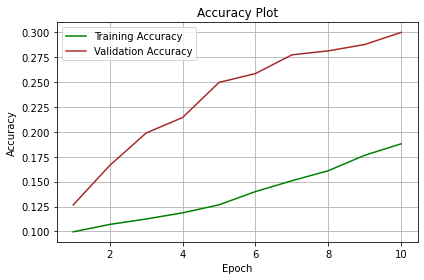

In [15]:
## Tracer la précision du modèle ##

plt.title('Accuracy Plot')
plt.plot(epochs, accuracy, 'green', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'brown', label='Validation Accuracy')
legend = plt.legend(loc='best', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('C0')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.grid(True)

plt.show()


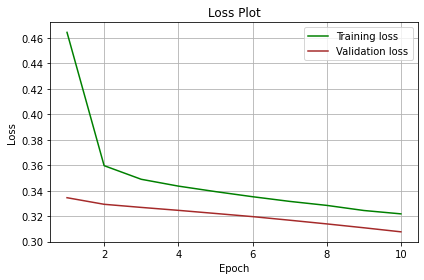

In [16]:
## Tracer la perte pour le modèle ##
plt.title('Loss Plot')
plt.plot(epochs, Train_loss, 'green', label='Training loss')
plt.plot(epochs, validation_loss, 'brown', label='Validation loss')
legend = plt.legend(loc='best', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('C0')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.grid(True)

plt.show()